# Linear Binary Pattern

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [68]:
from skimage import io
from skimage.feature import local_binary_pattern

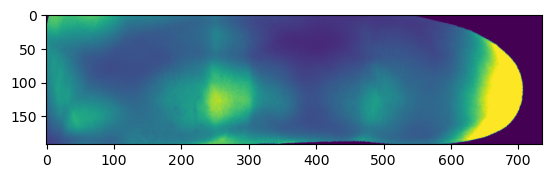

In [69]:
fingerprint = io.imread('../data/Data_FV_Spoofing_WS2025_26/PLUS/real/001/PLUS-FV3-Laser_PALMAR_001_01_02_01.png')
plt.imshow(fingerprint)
plt.show()

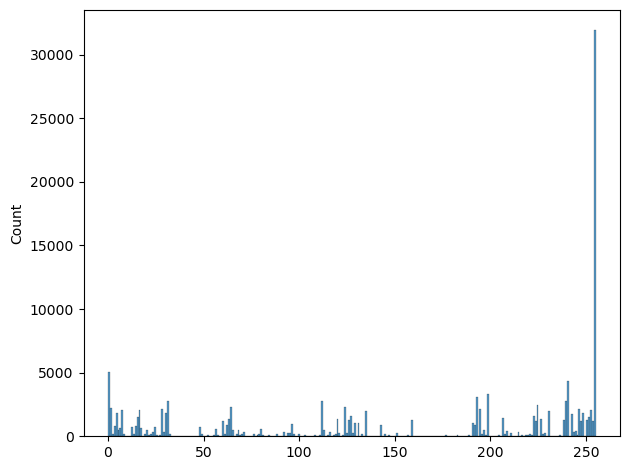

In [70]:
lbp = local_binary_pattern(fingerprint, P=8, R=1)
sns.histplot(lbp.ravel(), bins=256)
hist = np.bincount(lbp.ravel().astype(np.uint8))
plt.tight_layout()
plt.show()

## Preparing fingerprint data

In [71]:
import re
from pathlib import Path

def fingerprint_metadata(base_path, pattern):
    base_path = Path(base_path)
    return pd.DataFrame([(*pattern.findall(f.name)[0], f) for f in base_path.rglob('*.png')])

In [72]:
plus_pattern = re.compile(r"(.+)_(PALMAR|DORSAL)_([0-9]+)_([0-9]+)_([0-9]+)_([0-9]+).png")
idiap_pattern = re.compile(r"([0-9]+)_(L|R)_([0-9]+).png")
scut_pattern = re.compile(r"([0-9]+)_([0-9]+)_([0-9]+)_([0-9]+)_([0-9]+).bmp")
plus_map = {k:v for k,v in enumerate(['laser', 'side', 'subject', 'session', 'finger', 'image_id', 'path'])}
idiap_map = {k:v for k,v in enumerate(['subject', 'side', 'session', 'path'])}
scut_map = {k:v for k,v in enumerate(['subject', 'finger', 'session', 'shot', 'light', 'path'])}

# CHANGE PATH TO GET OTHER DATASETS
real = fingerprint_metadata('../data/Data_FV_Spoofing_WS2025_26/PLUS/real', plus_pattern).rename(columns=plus_map)
real['label'] = 'real'
spoof = fingerprint_metadata('../data/Data_FV_Spoofing_WS2025_26/PLUS/spoof/', plus_pattern).rename(columns=plus_map)
spoof['label'] = 'spoof'
real.head()

,laser,side,subject,session,finger,image_id,path,label
0,PLUS-FV3-Laser,PALMAR,001,01,02,01,..\data\Data_FV_Spoofing_WS2025_26\PLUS\real\0...,real
1,PLUS-FV3-Laser,PALMAR,001,01,02,02,..\data\Data_FV_Spoofing_WS2025_26\PLUS\real\0...,real
2,PLUS-FV3-Laser,PALMAR,001,01,02,03,..\data\Data_FV_Spoofing_WS2025_26\PLUS\real\0...,real
3,PLUS-FV3-Laser,PALMAR,001,01,02,04,..\data\Data_FV_Spoofing_WS2025_26\PLUS\real\0...,real
4,PLUS-FV3-Laser,PALMAR,001,01,02,05,..\data\Data_FV_Spoofing_WS2025_26\PLUS\real\0...,real


In [73]:
# CREATE THE BALANCED DATASET
KEYS = ["subject", "finger"]

# Identify shared (user_id, finger_id) pairs
common_keys = (
    real[KEYS]
    .merge(spoof[KEYS], on=KEYS, how="inner")
    .drop_duplicates()
)

# Filter both tables to the shared pairs
df_pos_balanced = real.merge(common_keys, on=KEYS, how="inner")
df_neg_balanced = spoof.merge(common_keys, on=KEYS, how="inner")

# Stack rows while preserving schema and labels
balanced_df = pd.concat(
    [df_pos_balanced, df_neg_balanced],
    ignore_index=True
)

balanced_df

,laser,side,subject,session,finger,image_id,path,label
0,PLUS-FV3-Laser,PALMAR,001,01,02,01,..\data\Data_FV_Spoofing_WS2025_26\PLUS\real\0...,real
1,PLUS-FV3-Laser,PALMAR,001,01,02,02,..\data\Data_FV_Spoofing_WS2025_26\PLUS\real\0...,real
2,PLUS-FV3-Laser,PALMAR,001,01,02,03,..\data\Data_FV_Spoofing_WS2025_26\PLUS\real\0...,real
3,PLUS-FV3-Laser,PALMAR,001,01,02,04,..\data\Data_FV_Spoofing_WS2025_26\PLUS\real\0...,real
4,PLUS-FV3-Laser,PALMAR,001,01,02,05,..\data\Data_FV_Spoofing_WS2025_26\PLUS\real\0...,real
...,...,...,...,...,...,...,...,...
1048,PLUS-FV3-Laser,PALMAR,057,01,07,02,..\data\Data_FV_Spoofing_WS2025_26\PLUS\spoof\...,spoof
1049,PLUS-FV3-Laser,PALMAR,057,01,08,01,..\data\Data_FV_Spoofing_WS2025_26\PLUS\spoof\...,spoof
1050,PLUS-FV3-Laser,PALMAR,057,01,08,02,..\data\Data_FV_Spoofing_WS2025_26\PLUS\spoof\...,spoof
1051,PLUS-FV3-Laser,PALMAR,057,01,09,01,..\data\Data_FV_Spoofing_WS2025_26\PLUS\spoof\...,spoof


In [74]:
# Takes fingerprint image path and converts it to a normalized histogram of the lbp results
def extract_feature(path: str) -> np.ndarray:
    fingerprint = io.imread(path)
    lbp = local_binary_pattern(fingerprint, P=8, R=1, method="default")
    lbp = lbp.astype(np.uint8)
    hist, _ = np.histogram(
        lbp.ravel(),
        bins=256,
        range=(0, 256)
    )
    hist = hist.astype(np.float32)
    hist /= hist.sum() + 1e-8
    return hist

In [75]:
# Add the feature column to the dataset
balanced_df['feature'] = balanced_df['path'].apply(extract_feature)

#Convert subject (user_id) to numeric
balanced_df["subject"] = pd.to_numeric(balanced_df["subject"], errors="coerce")
balanced_df

,laser,side,subject,session,finger,image_id,path,label,feature
0,PLUS-FV3-Laser,PALMAR,1,01,02,01,..\data\Data_FV_Spoofing_WS2025_26\PLUS\real\0...,real,"[0.03577191, 0.01568869, 0.0010544044, 0.00558..."
1,PLUS-FV3-Laser,PALMAR,1,01,02,02,..\data\Data_FV_Spoofing_WS2025_26\PLUS\real\0...,real,"[0.037717957, 0.01662987, 0.0010685575, 0.0050..."
2,PLUS-FV3-Laser,PALMAR,1,01,02,03,..\data\Data_FV_Spoofing_WS2025_26\PLUS\real\0...,real,"[0.036019586, 0.016700635, 0.0009341033, 0.005..."
3,PLUS-FV3-Laser,PALMAR,1,01,02,04,..\data\Data_FV_Spoofing_WS2025_26\PLUS\real\0...,real,"[0.03693246, 0.016424648, 0.0011110167, 0.0050..."
4,PLUS-FV3-Laser,PALMAR,1,01,02,05,..\data\Data_FV_Spoofing_WS2025_26\PLUS\real\0...,real,"[0.03599128, 0.016962467, 0.00096948596, 0.005..."
...,...,...,...,...,...,...,...,...,...
1048,PLUS-FV3-Laser,PALMAR,57,01,07,02,..\data\Data_FV_Spoofing_WS2025_26\PLUS\spoof\...,spoof,"[0.052614074, 0.017273834, 0.002002661, 0.0066..."
1049,PLUS-FV3-Laser,PALMAR,57,01,08,01,..\data\Data_FV_Spoofing_WS2025_26\PLUS\spoof\...,spoof,"[0.04252293, 0.018002717, 0.0021441916, 0.0076..."
1050,PLUS-FV3-Laser,PALMAR,57,01,08,02,..\data\Data_FV_Spoofing_WS2025_26\PLUS\spoof\...,spoof,"[0.060999773, 0.01781165, 0.0026749321, 0.0063..."
1051,PLUS-FV3-Laser,PALMAR,57,01,09,01,..\data\Data_FV_Spoofing_WS2025_26\PLUS\spoof\...,spoof,"[0.0546875, 0.0180381, 0.0018965127, 0.0070977..."


In [76]:
# Convert relevant columns to a list to input into 'crossvalidation'
data = balanced_df[['feature', 'label', 'subject']].values.tolist()
data[0]

[array([3.57719101e-02, 1.56886894e-02, 1.05440442e-03, 5.58339013e-03,
        1.30562158e-02, 3.51704028e-03, 4.83327685e-03, 1.47758154e-02,
        1.25962414e-03, 2.83061585e-04, 5.66123199e-05, 1.83990036e-04,
        5.09510888e-03, 1.00486865e-03, 5.94429346e-03, 1.09686367e-02,
        1.45352129e-02, 4.40160790e-03, 2.83061585e-04, 1.01194519e-03,
        3.39673902e-03, 6.36888610e-04, 9.90715576e-04, 2.44848290e-03,
        4.98188427e-03, 9.27026733e-04, 2.83061585e-04, 5.23663941e-04,
        1.51225654e-02, 2.48386548e-03, 1.28297666e-02, 1.97152402e-02,
        1.21008826e-03, 4.24592377e-04, 7.07653999e-06, 7.07653962e-05,
        3.39673919e-04, 9.19950180e-05, 7.07653962e-05, 2.26449280e-04,
        9.90715562e-05, 2.12296200e-05, 0.00000000e+00, 0.00000000e+00,
        2.26449280e-04, 5.66123199e-05, 1.55683883e-04, 3.11367767e-04,
        5.39939990e-03, 1.47899683e-03, 1.06148094e-04, 3.32597381e-04,
        9.69485962e-04, 2.05219651e-04, 2.26449280e-04, 7.784193

In [147]:
#Necaissairy to get rid of multiplicates

data_clean = []
seen = set()

for i in range(len(data)):
        combo = (data[i][1], data[i][2])  # hashable tuple
        if combo not in seen:
            data_clean.append(data[i])
            seen.add(combo)

len(data_clean)
for i in range(len(data_clean)):
    print(data_clean[2])

44

# Pipeline

In [148]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
import random
from itertools import combinations
from sklearn.metrics import confusion_matrix


def compute_error_rates(true_labels, pred_labels):
    """Compute APCER, BPCER, ACER."""
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)

    # Define mapping
    labels = ["real", "spoof"]  # Ensure consistent order

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=labels)
    print(cm)
    TN, FP, FN, TP = cm.ravel()  # Unpack the matrix

    apcer = FN/(FN+TP)
    bpcer = FP/(FP+TN)
    acer = 0.5 * (apcer + bpcer)
    return acer, apcer, bpcer

def train_on_size(trainsize, choices, data_folds, classifier):
    random.shuffle(choices)
    train = sum((data_folds[j] for j in choices[:trainsize]), [])
    random.shuffle(train)
    train_X = [row[0] for row in train]
    train_y = [row[1] for row in train]

    classifier.fit(train_X, train_y)
    return


def crossvalidation(data, dist='manhattan', k=5):
    """
    data: list of [feature_vector (np.array), label ('real'/'spoof'), user_id]

    dist: distance metric to be used by KNNeighborsClassifier

    k: neighbours for knn-classifier

    Returns:
       ACER, APCER, BPCER for:
        - training on 4/5
        - training on 2/5
        - training on 1/5
    """

    # Extract all unique users and create folds
    users = sorted({row[2] for row in data})
    random.shuffle(users)
    size = len(users) // 5
    user_folds = [users[i:i + size] for i in range(0, (len(users)//5)*5, size)]
    data_folds = [
        [row for row in data if row[2] in user_folds[i]]
        for i in range(5)
    ]

    results = {
        "4_of_5": [],
        "2_of_5": [],
        "1_of_5": []
    }

    for i in range(5):
        test_set = data_folds[i]
        test_X = [row[0] for row in test_set]
        test_y = [row[1] for row in test_set]
        choices = list({0, 1, 2, 3, 4} - {i})
        
        # train on 4
        knn = KNeighborsClassifier(n_neighbors=k,metric=dist)
        train_on_size(4, choices, data_folds, knn)
        predictions = knn.predict(test_X)
        acer, apcer, bpcer = compute_error_rates(test_y, predictions)
        results["4_of_5"].append((acer, apcer, bpcer))

        # train on 2
        knn = KNeighborsClassifier(n_neighbors=k,metric=dist)
        train_on_size(2, choices, data_folds, knn)
        predictions = knn.predict(test_X)
        acer, apcer, bpcer = compute_error_rates(test_y, predictions)
        results["2_of_5"].append((acer, apcer, bpcer))

        # train on 1
        knn = KNeighborsClassifier(n_neighbors=k,metric=dist)
        train_on_size(1, choices, data_folds, knn)
        predictions = knn.predict(test_X)
        acer, apcer, bpcer = compute_error_rates(test_y, predictions)
        results["1_of_5"].append((acer, apcer, bpcer))

        
        
    final = {}
    for regime in results:
        arr = np.array(results[regime])
        final[regime] = {
            "ACER":  float(arr[:, 0].mean()),
            "APCER": float(arr[:, 1].mean()),
            "BPCER": float(arr[:, 2].mean())
        }

    return final

In [149]:
indices = np.random.permutation(len(data))[:200]
cut_data = [data[i] for i in indices]

In [150]:
# call crossvalidate with the prepared dataset
crossvalidation(data)

[[120   0]
 [  0  69]]
[[120   0]
 [  0  69]]
[[120   0]
 [  0  69]]
[[120   0]
 [  0  72]]
[[120   0]
 [  0  72]]
[[120   0]
 [  0  72]]
[[120   0]
 [  0  72]]
[[120   0]
 [  0  72]]
[[120   0]
 [  0  72]]
[[120   0]
 [  0  72]]
[[120   0]
 [  0  72]]
[[120   0]
 [  0  72]]
[[120   0]
 [  0  72]]
[[120   0]
 [  0  72]]
[[120   0]
 [  0  72]]


{'4_of_5': {'ACER': 0.0, 'APCER': 0.0, 'BPCER': 0.0},
 '2_of_5': {'ACER': 0.0, 'APCER': 0.0, 'BPCER': 0.0},
 '1_of_5': {'ACER': 0.0, 'APCER': 0.0, 'BPCER': 0.0}}

In [151]:
def generate_dummy_data(num_samples=10):
    data = []

    for i in range(num_samples):
        vector = [random.random() for _ in range(5)]  # length-5 vector
        label = "real"
        unique_id = str(i)

        data.append([vector, label, unique_id])

        vector = [random.random() for _ in range(5)]  # length-5 vector
        label = "spoof"
        unique_id = str(i)

        data.append([vector, label, unique_id])

    return data

dummy_data = generate_dummy_data(200)

crossvalidation(dummy_data)

[[19 21]
 [23 17]]
[[21 19]
 [19 21]]
[[22 18]
 [18 22]]
[[13 27]
 [23 17]]
[[15 25]
 [20 20]]
[[14 26]
 [17 23]]
[[15 25]
 [26 14]]
[[19 21]
 [23 17]]
[[17 23]
 [19 21]]
[[21 19]
 [25 15]]
[[21 19]
 [16 24]]
[[14 26]
 [19 21]]
[[17 23]
 [20 20]]
[[23 17]
 [23 17]]
[[22 18]
 [20 20]]


{'4_of_5': {'ACER': 0.58, 'APCER': 0.585, 'BPCER': 0.575},
 '2_of_5': {'ACER': 0.5050000000000001,
  'APCER': 0.5049999999999999,
  'BPCER': 0.505},
 '1_of_5': {'ACER': 0.51, 'APCER': 0.465, 'BPCER': 0.555}}

In [153]:
crossvalidation(data_clean)

[[4 0]
 [0 4]]
[[4 0]
 [0 4]]
[[4 0]
 [0 4]]
[[4 0]
 [0 4]]
[[4 0]
 [0 4]]
[[4 0]
 [0 4]]
[[4 0]
 [0 4]]
[[4 0]
 [0 4]]
[[4 0]
 [0 4]]
[[4 0]
 [0 4]]
[[4 0]
 [0 4]]
[[4 0]
 [0 4]]
[[4 0]
 [0 4]]
[[4 0]
 [0 4]]
[[4 0]
 [0 4]]


{'4_of_5': {'ACER': 0.0, 'APCER': 0.0, 'BPCER': 0.0},
 '2_of_5': {'ACER': 0.0, 'APCER': 0.0, 'BPCER': 0.0},
 '1_of_5': {'ACER': 0.0, 'APCER': 0.0, 'BPCER': 0.0}}